In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.49.0


In [3]:
ws = Workspace.get(
    name='schimek_mpt_eastus2',
    subscription_id='9c49afdd-cccb-44e2-a4eb-5b2f941c774c',
    resource_group='schimek_cloud',
    location='eastus2')

In [4]:
from azureml.core import Experiment

script_folder = './tf-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='tf-mnist')


In [5]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'))

('/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/data/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x7f833a095a90>)

In [6]:

import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

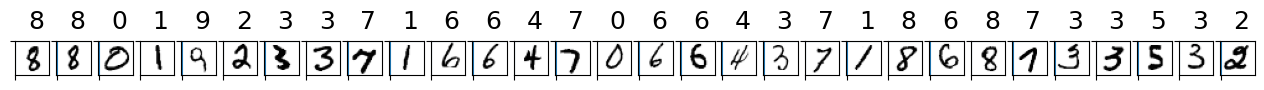

In [7]:
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images-idx3-ubyte.gz'), False) / np.float32(255.0)
X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / np.float32(255.0)
y_train = load_data(os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

In [8]:
from azureml.core.dataset import Dataset
web_paths = ['https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

In [9]:
from azureml.exceptions import UserErrorException
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'mnist-dataset')
    dataset_registered = True
except UserErrorException:
    print("The dataset mnist-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'mnist-dataset',
                               description='training and test dataset',
                               create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

['/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz']

In [10]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "nlsschim-gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# can poll for a minimum number of nodes and for a specific timeout. 
# if no min node count is provided it uses the scale settings for the cluster
compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2023-03-30T22:33:36.348000+00:00', 'errors': None, 'creationTime': '2023-03-30T22:33:31.869377+00:00', 'modifiedTime': '2023-03-30T22:33:35.839923+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 1, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NV6'}


In [11]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

nlsschim-gpu-cluster AmlCompute Succeeded


In [12]:
import shutil

# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./tf-mnist/utils.py'

In [13]:
with open(os.path.join(script_folder, './tf_mnist.py'), 'r') as f:
    print(f.read())

import numpy as np
import argparse
import os
import re
import tensorflow as tf
import time
import glob

from azureml.core import Run
from utils import load_data
from tensorflow.keras import Model, layers


# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First hidden layer.
        self.h1 = layers.Dense(n_h1, activation=tf.nn.relu)
        # Second hidden layer.
        self.h2 = layers.Dense(n_h2, activation=tf.nn.relu)
        self.out = layers.Dense(n_outputs)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.h1(x)
        x = self.h2(x)
        x = self.out(x)
        if not is_training:
            # Apply softmax when not training.
            x = tf.nn.softmax(x)
        return x


def cross_entropy_loss(y, logits):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entro

In [14]:
from azureml.core import Environment

tf_env = Environment.get(ws, name='AzureML-tensorflow-2.6-ubuntu20.04-py38-cuda11-gpu')

In [15]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', dataset.as_named_input('mnist').as_mount(),
        '--batch-size', 64,
        '--first-layer-neurons', 256,
        '--second-layer-neurons', 128,
        '--learning-rate', 0.01]

src = ScriptRunConfig(source_directory=script_folder,
                      script='tf_mnist.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env)

In [16]:
run = exp.submit(src)

Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exce

In [18]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…